# Static Graph Predictions - GraphSAGE
This notebook demonstrates the loading of data from the synethetic dataset into tensors that are then used in Pytorch Geometric. We then perform predictions on the final proportion of Heroin individuals in the models. Each prediction is done on a static graph at a given time step. Please see report for more details.

We recommend loading this into Colab to run because the runtime of the GNNs is quite slow without GPUs.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 24.2MB/s 
     |████████████████████████████████| 1.5MB 36.3MB/s 
     |████████████████████████████████| 215kB 20.4MB/s 
     |████████████████████████████████| 235kB 52.0MB/s 
     |████████████████████████████████| 2.2MB 52.7MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 


In [4]:
import sys, os
import numpy as np
from collections import Counter
import warnings

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.data import Data, GraphSAINTRandomWalkSampler, DataLoader, Dataset
from torch_geometric.datasets import Planetoid, Entities
from torch_geometric.nn import GCNConv, RGCNConv, GATConv, SAGEConv, JumpingKnowledge, GINConv, DeepGraphInfomax, global_mean_pool
from torch_geometric.utils.convert import from_networkx, to_networkx

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# To load in the data from pickles:
import pickle, os
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

In [5]:
class Hyperparameters():
  def __init__(self):
    self.num_node_features = None
    self.num_classes = None
    self.lr = 0.005
    self.w_decay = 5e-4   
    self.dropout = 0.3
    self.epochs = 200                
    self.cuda = True                
    self.device  =  None 
    self.batch_size = 32 

args = Hyperparameters()
args.cuda = torch.cuda.is_available() 
if args.cuda:
    args.device = torch.device('cuda:0') # Change device here 
else:
    args.device = torch.device('cpu')
    
print(args.device)

cuda:0


In [6]:
nx_objects = pickle.load(open('Data/net_1000.pickle', 'rb'))

In [7]:
# Loading data:
group_to_onehot = {
    'S': (1, 0, 0, 0, 0),
    'P': (0, 1, 0, 0, 0),
    'A': (0, 0, 1, 0, 0),
    'H': (0, 0, 0, 1, 0),
    'R': (0, 0, 0, 0, 1)
}

# Gets final proportions of individuals in the graph with a given group
def get_ending_proportions(obj_list, group = 'H'):
  prop_list = []
  for i in range(len(obj_list)):
    subl = obj_list[i]
    group_last = nx.get_node_attributes(subl[-1], 'group')
    group_count = dict(Counter(group_last.values()))
    prop_list.append(group_count[group_to_onehot[group]] / subl[-1].number_of_nodes())
  return prop_list
    
end_prop = get_ending_proportions(nx_objects)
Y = end_prop # Set Y value (can be anything)

In [8]:
# Functions to get initial graphs:

def conv_to_undirected(edges):
  undirected_edges = list(edges)
  for e in edges:
    undirected_edges.append([e[1], e[0]])
  return undirected_edges


def get_X_static(tstep = 0):
  '''
  Gets the X for one network in a series
  Arguments:
  ----------
  tstep: integer
  '''

  X = []

  for i in range(0, len(nx_objects)):
    edge_list = conv_to_undirected(nx_objects[i][tstep].edges)
    edge_index = torch.tensor(edge_list, dtype=torch.long).to(args.device)
    node_attr = dict(nx.get_node_attributes(nx_objects[i][tstep], 'group'))
    # Order the node attributes:
    x = torch.tensor(
        [node_attr[i] 
        for i in range(len(nx_objects[i][tstep].nodes))], dtype = torch.float
    ).to(args.device)
    d = Data(x=x, edge_index=edge_index.t().contiguous())
    X.append([d, Y[i]])

  return X

def train_val_split(dataset, X, val_split = 0.25):
  '''Split data into train-validation split'''

  train_ind, val_ind = train_test_split(list(range(len(dataset))), test_size = val_split)
  train = [X[t] for t in train_ind]
  val = [X[v] for v in val_ind]

  # Puts all training and val data in a DataLoader wrapper
  train_dataset = DataLoader(train, batch_size = 64, shuffle = True)
  val_dataset = DataLoader(val, batch_size = 64, shuffle = False)
  return train_dataset, val_dataset

In [9]:
time_step = 95 # Which time step to evaluate

X_full = get_X_static(tstep = time_step)
print('Number of samples', len(X_full))

dataset = X_full
train_dataset, val_dataset = train_val_split(dataset, X_full, val_split = 0.25)

Number of samples 1000


## Define the Models
Define each of the GNN architectures to use. Each architecture varies the number of convolutional layers. 

**Terminology:**
- Hidden channels: number of dimensions for embedding vectors within the message-passing layers.

In [10]:
class GNN3(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN3, self).__init__()
        self.conv1 = SAGEConv(5, hidden_channels)
        self.lin = Linear(hidden_channels, 1) # One value in output
        self.sig = nn.Sigmoid()

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.25, training=self.training)

        # Since we have a proportion to predict, squashing to [0,1]
        x = self.lin(x)
        
        return x

gnn_description = 'SAGE Conv 1 layers, 64 hidden channels each, drop=0.25'
gnn_no = 3

In [11]:
class GNN2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN2, self).__init__()
        self.conv1 = SAGEConv(5, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1) # One value in output
        self.sig = nn.Sigmoid()

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.25, training=self.training)

        # Since we have a proportion to predict, squashing to [0,1]
        x = self.lin(x)
        
        return x

gnn_description = 'SAGE Conv 2 layers, 64 hidden channels each, drop=0.25'
gcn_no = 2

In [12]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(5, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1) # One value in output
        self.sig = nn.Sigmoid()

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.25, training=self.training)

        # Since we have a proportion to predict, squashing to [0,1]
        x = self.lin(x)
        
        return x
    
gnn_description = 'SAGE Conv 3 layers, 64 hidden channels each, drop=0.25'
gnn_no = 1

## Training the Models
In the below block, we train a defined model with the given hyperparameters, plotting an accuracy curve upon completion.

Epoch: 000, Train R^2: -0.8316, Test R^2: -0.9885
Epoch: 001, Train R^2: -0.2103, Test R^2: -0.1146
Epoch: 002, Train R^2: -0.1398, Test R^2: -0.2092
Epoch: 003, Train R^2: 0.0045, Test R^2: 0.0204
Epoch: 004, Train R^2: -0.0108, Test R^2: -0.0074
Epoch: 005, Train R^2: 0.0052, Test R^2: 0.0036
Epoch: 006, Train R^2: 0.0157, Test R^2: 0.0094
Epoch: 007, Train R^2: 0.0136, Test R^2: -0.0093
Epoch: 008, Train R^2: 0.0118, Test R^2: -0.0075
Epoch: 009, Train R^2: 0.0017, Test R^2: -0.0056
Epoch: 010, Train R^2: -0.0462, Test R^2: -0.0997
Epoch: 011, Train R^2: 0.0135, Test R^2: -0.0037
Epoch: 012, Train R^2: -0.0040, Test R^2: -0.0268
Epoch: 013, Train R^2: -0.0524, Test R^2: -0.0364
Epoch: 014, Train R^2: -0.0022, Test R^2: -0.0129
Epoch: 015, Train R^2: 0.0054, Test R^2: -0.0255
Epoch: 016, Train R^2: -0.0058, Test R^2: -0.0095
Epoch: 017, Train R^2: -0.0157, Test R^2: -0.0165
Epoch: 018, Train R^2: -0.0434, Test R^2: -0.0335
Epoch: 019, Train R^2: -0.0089, Test R^2: -0.0339
Epoch: 020,

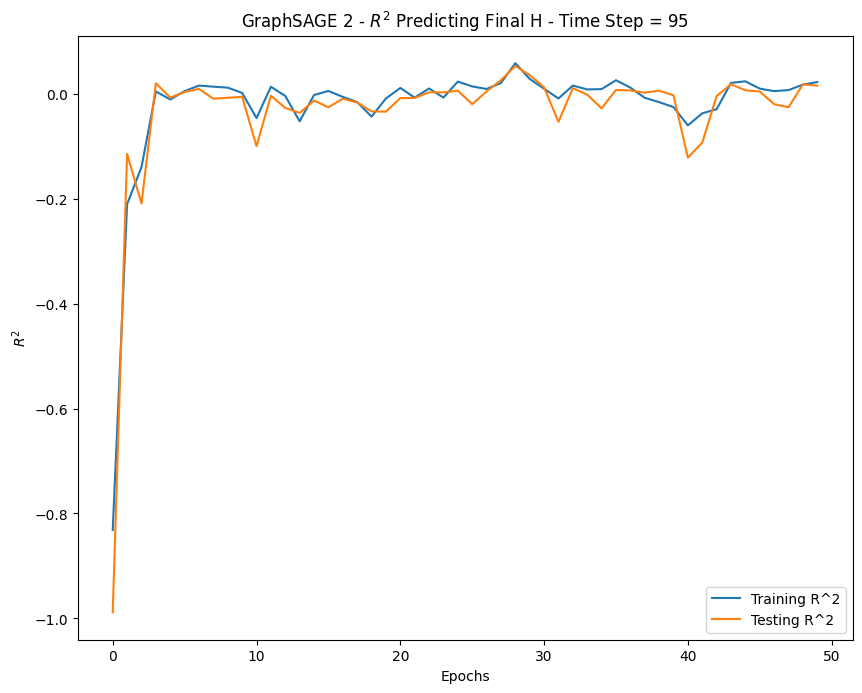

In [14]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  hc = 64 # Number of hidden channels
  model = GNN3(hidden_channels=hc).to(device=args.device)
  gnn_no = 3
  learn_r = 0.01 # Learning rate
  optimizer = torch.optim.Adam(model.parameters(), lr=learn_r)
  criterion = torch.nn.MSELoss()

  epochs = 50

  def train():
    '''Trains the model'''
    model.train()

    for Xdata, Ydata in train_dataset:  # Iterate in batches over the training dataset.
      #print('Epoch', i)
      #print(data)
      out = model(Xdata.x.to(args.device), Xdata.edge_index.to(args.device), Xdata.batch.to(args.device))  # Perform a single forward pass.
      loss = criterion(out, Ydata.to(args.device))  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      optimizer.zero_grad()  # Clear gradients.

  def test(loader):
    model.eval()

    preds = []
    gt = []
    for Xdata, Ydata in loader:  # Iterate in batches over the training/test dataset.
      pred = model(Xdata.x.to(args.device), Xdata.edge_index.to(args.device), Xdata.batch.to(args.device)) 
      preds.append(pred.cpu().detach().numpy())
      gt.append(Ydata.detach().numpy())

    return r2_score(np.concatenate(gt), np.concatenate(preds))

  train_curve = []
  test_curve = []
  for epoch in range(0, epochs):
    train()
    train_acc = test(train_dataset)
    train_curve.append(train_acc)
    test_acc = test(val_dataset)
    test_curve.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train R^2: {train_acc:.4f}, Test R^2: {test_acc:.4f}')

results = pd.DataFrame({'train_results':train_curve, 'test_curve':test_curve})
results['model'] = [gnn_description] + [None] * (len(train_curve) - 1)

#results.to_csv(f'gnn_{gnn_no}_layer_curves_t=95.csv')
#results.to_csv(f'gnn_lr={learn_r}_curves_t=95.csv', index = False)
#results.to_csv(f'gnn_hc={hc}_curves_t=95.csv', index = False)
results.to_csv(f'curves_t={time_step}.csv', index = False)

plt.figure(figsize=(10, 8), dpi = 100)
plt.plot(list(range(epochs)), train_curve, label = 'Training R^2')
plt.plot(list(range(epochs)), test_curve, label = 'Testing R^2')
plt.legend()
plt.title('GraphSAGE {} - $R^2$ Predicting Final H - Time Step = {}'.format(gcn_no, time_step))
plt.xlabel('Epochs')
plt.ylabel('$R^2$')
plt.show()


## Plotting Tools
The code below was used to plot the accuracy curves. Please do not run this code, it is simply here for demonstration purposes. 

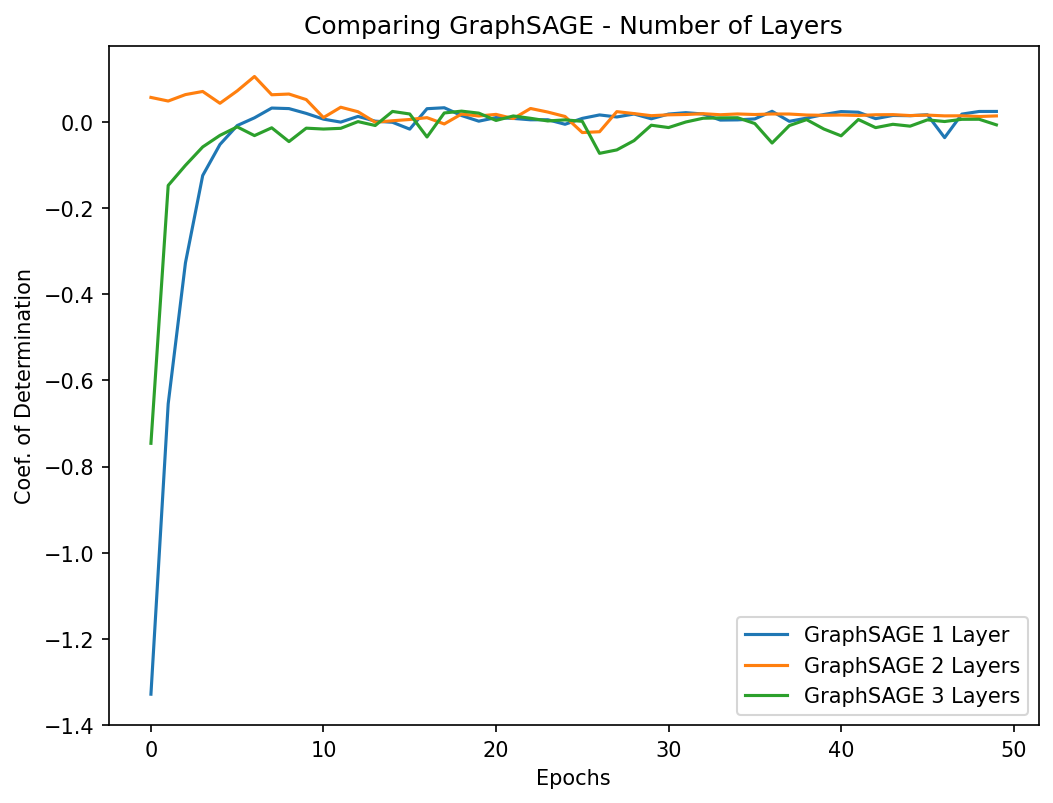

In [ ]:
import matplotlib.pyplot as plt

gnn3 = pd.read_csv('gnn_3_layer_curves_t=95.csv')
gnn2 = pd.read_csv('gnn_2_layer_curves_t=95.csv')
gnn1 = pd.read_csv('gnn_1_layer_curves_t=95.csv')

labels = ['GraphSAGE 1 Layer', 'GraphSAGE 2 Layers', 'GraphSAGE 3 Layers']

x = list(range(0, gnn1.shape[0]))

plt.figure(figsize=(8, 6), dpi = 150)
plt.plot(x, gnn3['test_curve'], label = labels[0])
plt.plot(x, gnn2['test_curve'], label = labels[1])
plt.plot(x, gnn1['test_curve'], label = labels[2])

plt.title('Comparing GraphSAGE - Number of Layers')
plt.xlabel('Epochs')
plt.ylabel('Coef. of Determination')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


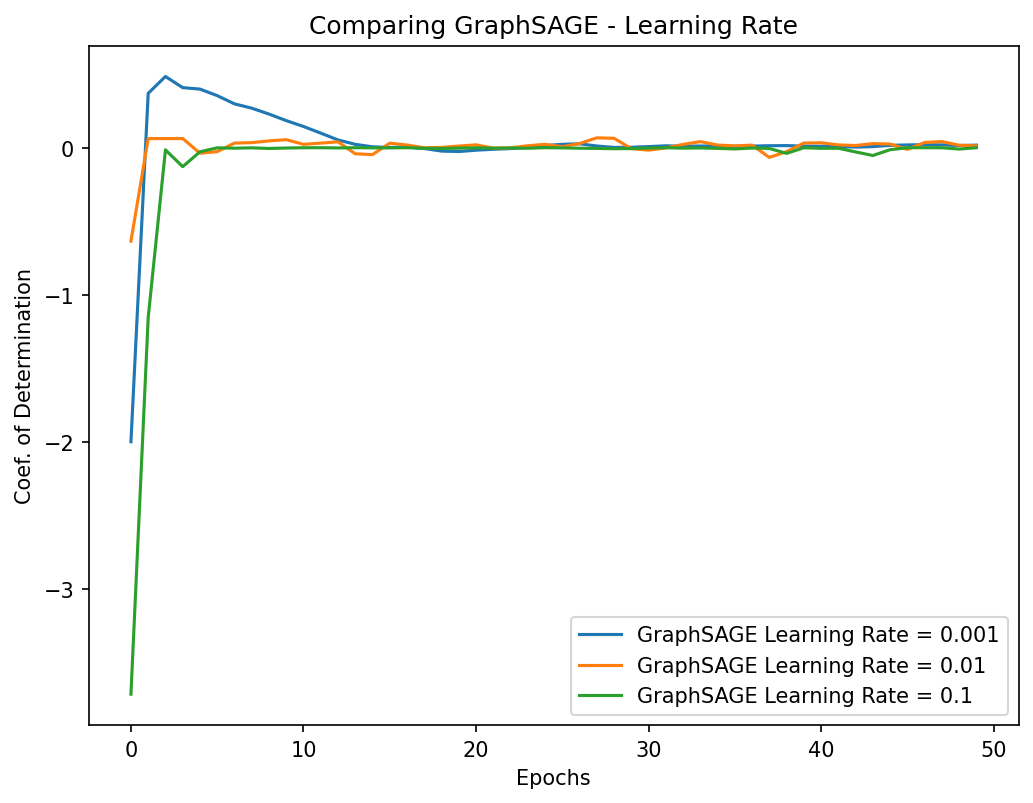

In [ ]:
import matplotlib.pyplot as plt

lrs = [0.001, 0.01, 0.1]

gnn3 = pd.read_csv(f'gnn_lr={lrs[0]}_curves_t=95.csv')
gnn3['test_curve'].iloc[0] = -2.0
gnn2 = pd.read_csv(f'gnn_lr={lrs[1]}_curves_t=95.csv')
gnn1 = pd.read_csv(f'gnn_lr={lrs[2]}_curves_t=95.csv')

labels = [f'GraphSAGE Learning Rate = {lrs[i]}' for i in range(len(lrs))]

x = list(range(0, gnn1.shape[0]))

plt.figure(figsize=(8, 6), dpi = 150)
plt.plot(x, gnn3['test_curve'], label = labels[0])
plt.plot(x, gnn2['test_curve'], label = labels[1])
plt.plot(x, gnn1['test_curve'], label = labels[2])

plt.title('Comparing GraphSAGE - Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Coef. of Determination')
plt.legend()
plt.show()

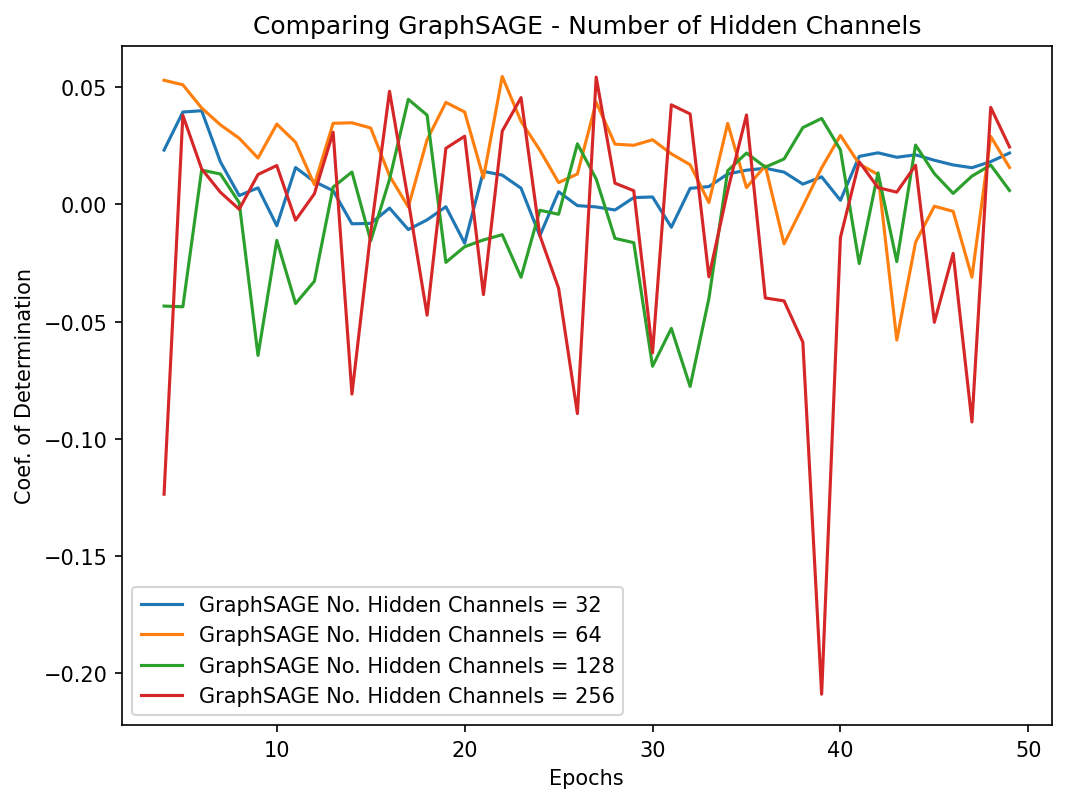

In [ ]:
import matplotlib.pyplot as plt

hcs = [32, 64, 128, 256]

gnn4 = pd.read_csv(f'gnn_hc={hcs[0]}_curves_t=95.csv')
gnn3 = pd.read_csv(f'gnn_hc={hcs[1]}_curves_t=95.csv')
gnn2 = pd.read_csv(f'gnn_hc={hcs[2]}_curves_t=95.csv')
gnn1 = pd.read_csv(f'gnn_hc={hcs[3]}_curves_t=95.csv')

gnns = [gnn4, gnn3, gnn2, gnn1]

labels = [f'GraphSAGE No. Hidden Channels = {hcs[i]}' for i in range(len(hcs))]

x = list(range(0, gnn1.shape[0]))

bottom = 4

plt.figure(figsize=(8, 6), dpi = 150)

for i in range(len(hcs)):
  plt.plot(x[bottom:], gnns[i]['test_curve'].iloc[bottom:], label = labels[i])

plt.title('Comparing GraphSAGE - Number of Hidden Channels')
plt.xlabel('Epochs')
plt.ylabel('Coef. of Determination')
plt.legend()
plt.show()

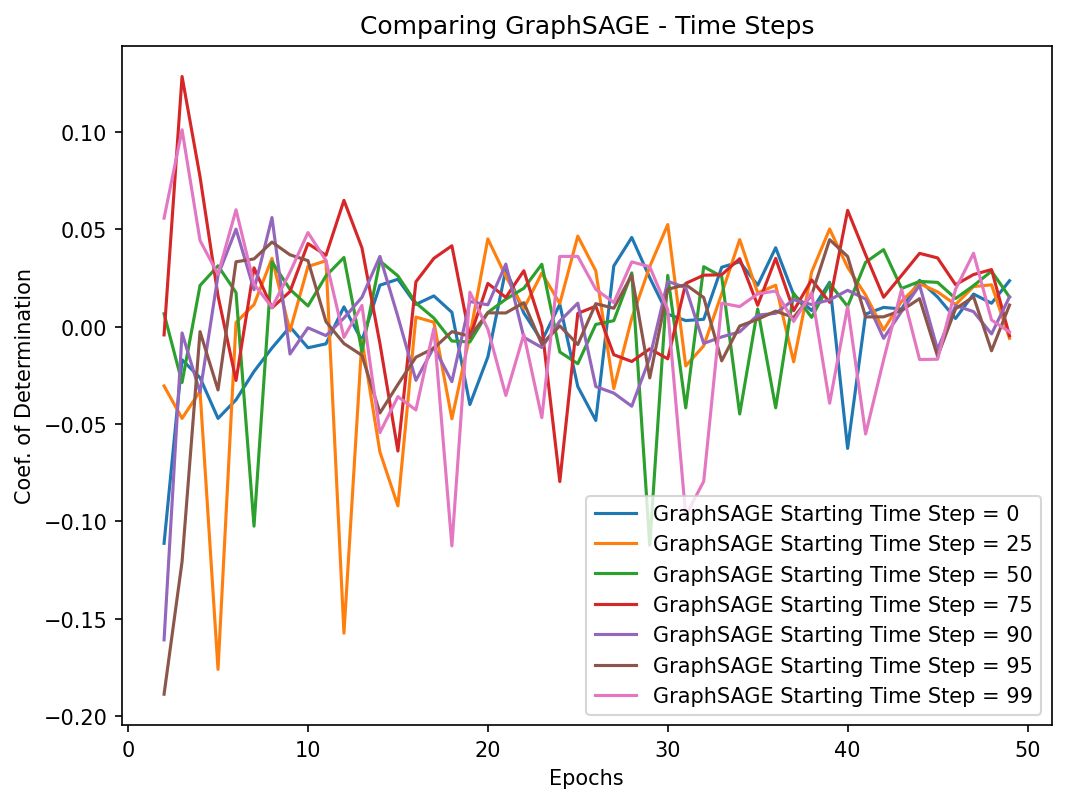

In [ ]:
import matplotlib.pyplot as plt

t = [0, 25, 50, 75, 90, 95, 99]

gnns = []

for i in range(len(t)):
  gnn_temp = pd.read_csv(f'curves_t={t[i]}.csv')
  gnns.append(gnn_temp)

labels = [f'GraphSAGE Starting Time Step = {t[i]}' for i in range(len(t))]

x = list(range(0, gnns[0].shape[0]))

bottom = 2

plt.figure(figsize=(8, 6), dpi = 150)

for i in range(len(t)):
  plt.plot(x[bottom:], gnns[i]['test_curve'].iloc[bottom:], label = labels[i])
  


plt.title('Comparing GraphSAGE - Time Steps')
plt.xlabel('Epochs')
plt.ylabel('Coef. of Determination')
plt.legend()
plt.show()